In [1]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
# Algorithms
from scipy import stats
import seaborn as sns
import datetime as dt
import ast
import plotly.express as px
import scipy
from datetime import date, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Birthing Data
df_birth = pd.read_csv(r'/datasets/bump/bump/redcap/birthing_data.csv.gz')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date

# Oura
df_sleep = pd.read_csv(r'/datasets/bump/bump/oura/oura_sleep.csv.gz')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

def secToTime(sec):
    return dt.timedelta(seconds =sec)

df_sleep['duration_time'] = df_sleep['duration'].apply(lambda x: x if pd.isnull(x) else secToTime(x))
df_sleep['duration_min'] = df_sleep['duration'].apply(lambda x: x if pd.isnull(x) else x/60)

df_readiness = pd.read_csv(r'/datasets/bump/bump/oura/oura_readiness.csv.gz')
df_readiness['date'] = pd.to_datetime(df_readiness.event_date).dt.date

df_activity = pd.read_csv(r'/datasets/bump/bump/oura/oura_activity.csv.gz')
df_activity['date'] = pd.to_datetime(df_activity.event_date).dt.date

In [4]:
# Install Font
path = 'LinLibertine_R.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=path, size=20)
fontproptitle = fm.FontProperties(fname=path, size=30)

# No Display Limit
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# pd.set_option('display.max_rows', 50)
# pd.set_option('display.max_columns', 50)

In [5]:
def duration(input_str, date_variable):
    # Remove non-numeric characters
    if pd.isna(input_str):
        # print('Invalid input format')
        return ''

    input_str = ''.join(filter(str.isdigit, input_str))

    # Convert string to integers
    try:
        weeks = 0
        days = 0
        if len(input_str) > 3:
            # print('Invalid input format')
            return ''
        if len(input_str) == 3:
            weeks = int(input_str[:-1])
            days = int(input_str[-1:])
        if len(input_str) == 2:
            weeks = int(input_str)
            days = 0
    except ValueError:
        raise ValueError("Invalid input format")
    # Calculate days
    total_days = (weeks * 7) + days
    
    duration = timedelta(days=total_days)

    return duration


df_birth['duration'] = df_birth.apply(lambda x: duration(x['birth_gestage'], x['date']), axis=1)
df_birth['duration'] = pd.to_timedelta(df_birth['duration'])
df_birth['conception'] = df_birth.apply(lambda row: pd.to_datetime(row['birth_date']) - row['duration'], axis=1)

In [6]:
def calculate_gestational_age(df, df_birth):
    # Create a mapping of record_ids to their conception date from df_birth
    conception_dates = df_birth.set_index('record_id')['conception'].to_dict()
    
    # Calculate gestational age
    def gestational_age(row):
        conception_date = conception_dates.get(row['record_id'])
        if pd.isnull(conception_date):
            return None
        return (row['date'] - conception_date).days
    
    df['gestationalAge'] = df.apply(gestational_age, axis=1)
    
    return df

In [7]:
conceptionSleep = df_sleep.copy()
# First, create a mapping of record_ids to the conception date
record_id_to_conception_date = dict(zip(df_birth.record_id, df_birth.conception))

# Ensure that the 'date' column in conceptionSleep is of type datetime for comparison
conceptionSleep['date'] = pd.to_datetime(conceptionSleep['date'])

# Now, filter the copied DataFrame based on the mapping
conceptionSleep = conceptionSleep[conceptionSleep.apply(lambda x: x.date >= record_id_to_conception_date.get(x.record_id, pd.to_datetime('1970-01-01')), axis=1)]
sleepTest = calculate_gestational_age(conceptionSleep, df_birth)
sleepTest

,id,user_id,identity_id,created_at,updated_at,retrieved_at,subsource,event_date,awake,bedtime_end,...,temperature_delta,temperature_deviation,temperature_trend_deviation,timezone,total,record_id,date,duration_time,duration_min,gestationalAge
0,1966732,992,2269,2021-10-25 11:03:03.125937,2021-10-25 11:03:03.125937,2021-10-24 00:00:00,sleep,2021-10-25 00:00:00,2100.0,2021-10-25 06:54:38,...,0.00,0.00,-0.01,-240.0,27360.0,sema4_348,2021-10-25,0 days 08:11:00,491.0,101.0
1,1931630,992,2269,2021-10-23 14:03:07.112152,2021-10-23 14:03:07.112152,2021-10-22 00:00:00,sleep,2021-10-23 00:00:00,2580.0,2021-10-23 08:45:12,...,-0.21,-0.21,-0.02,-240.0,26340.0,sema4_348,2021-10-23,0 days 08:02:00,482.0,99.0
2,1912104,992,2269,2021-10-22 12:02:59.334327,2021-10-22 12:02:59.334327,2021-10-21 00:00:00,sleep,2021-10-22 00:00:00,1620.0,2021-10-22 07:04:20,...,-0.03,-0.03,0.03,-240.0,28320.0,sema4_348,2021-10-22,0 days 08:19:00,499.0,98.0
3,1900559,992,2269,2021-10-21 23:03:01.419843,2021-10-21 23:03:01.419843,2021-10-20 00:00:00,sleep,2021-10-21 00:00:00,2100.0,2021-10-21 07:01:02,...,-0.09,-0.09,0.01,-240.0,26340.0,sema4_348,2021-10-21,0 days 07:54:00,474.0,97.0
4,1888358,992,2269,2021-10-21 01:02:58.589422,2021-10-21 01:02:58.589422,2021-10-19 00:00:00,sleep,2021-10-20 00:00:00,2700.0,2021-10-20 06:44:30,...,0.05,0.05,NaN,-240.0,25860.0,sema4_348,2021-10-20,0 days 07:56:00,476.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78839,6055887,2006,6606,2022-04-03 13:03:12.924679,2022-04-03 13:03:12.924679,2022-04-02 00:00:00,sleep,2022-04-03 00:00:00,3690.0,2022-04-03 08:15:24,...,-0.03,-0.03,0.04,-240.0,28230.0,sema4_715,2022-04-03,0 days 08:52:00,532.0,127.0
78840,6022232,2006,6606,2022-04-02 12:03:21.47268,2022-04-02 12:03:21.47268,2022-04-01 00:00:00,sleep,2022-04-02 00:00:00,2460.0,2022-04-02 07:33:12,...,0.02,0.02,0.04,-240.0,29340.0,sema4_715,2022-04-02,0 days 08:50:00,530.0,126.0
78841,5992165,2006,6606,2022-04-01 10:03:10.300444,2022-04-01 10:03:10.300444,2022-03-31 00:00:00,sleep,2022-04-01 00:00:00,4740.0,2022-04-01 06:00:51,...,-0.03,-0.03,0.00,-240.0,26940.0,sema4_715,2022-04-01,0 days 08:48:00,528.0,125.0
78842,5970899,2006,6606,2022-03-31 10:03:07.23187,2022-03-31 10:03:07.23187,2022-03-30 00:00:00,sleep,2022-03-31 00:00:00,3930.0,2022-03-31 05:45:38,...,-0.08,-0.08,0.00,-240.0,24210.0,sema4_715,2022-03-31,0 days 07:49:00,469.0,124.0


In [8]:
# Convert to weeks
df_birth['gestation_weeks'] = df_birth['duration'].dt.days // 7

# Filter based on gestation
preterm_group = df_birth[df_birth['gestation_weeks'].between(20, 37, inclusive='left')]['record_id'].tolist()
term_group = df_birth[df_birth['gestation_weeks'].between(37, 42, inclusive='left')]['record_id'].tolist()



In [9]:
# Calculate days before and after delivery
def findDaysSince(df):
    
    df2 = []
   
    # for every unique user
    for record_id in df.record_id.unique():
        
        if (len(df_birth.loc[df_birth.record_id == record_id]) != 0):
            birth = df_birth.loc[df_birth.record_id == record_id].reset_index()
            birthDate = birth['date'][0]
            # If the birth date is not null
            if (pd.isnull(birthDate) == False):
                # Get individual dataframe
                userDF = df[df['record_id'] == record_id]
                # For every date in the dataframe, add a new column value for days since birth
                userDF['daysSince'] = userDF.apply(lambda row: row.date - birthDate, axis=1)
                df2.append(userDF)
    return pd.concat(df2, ignore_index=True)

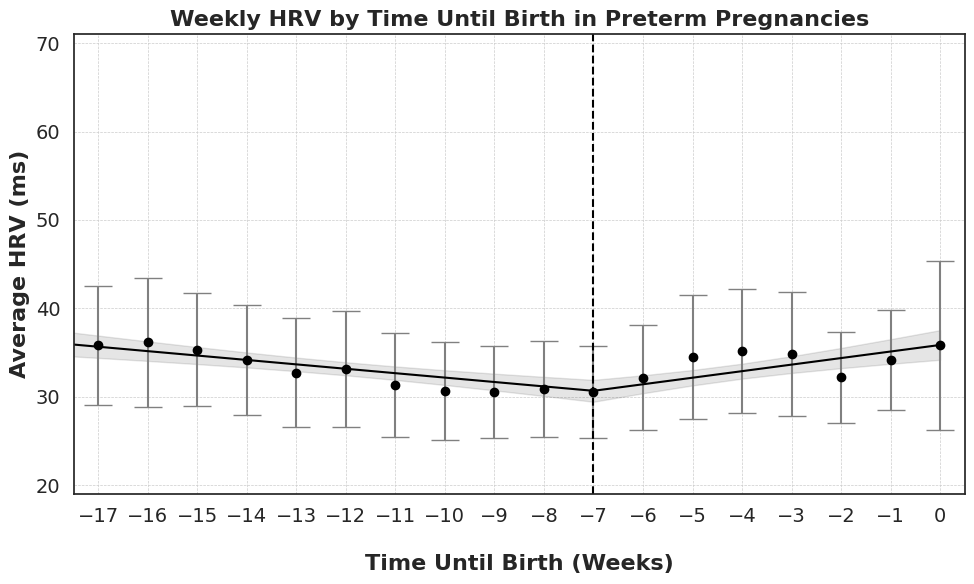

In [26]:
# Preprocess and calculate necessary columns
df = findDaysSince(df_sleep)
# Only include id's within the term group
df = df[df['record_id'].isin(preterm_group)]

df['daysSince'] = df['daysSince'] / np.timedelta64(1, 'D')
df['weeksSince'] = np.floor(df['daysSince'] / 7)
# remove rows with na values in rmssd
df = df.dropna(subset=['rmssd'])

# Filter from week 24 to delivery
df_filtered = df[(df['weeksSince'] >= -18) & (df['weeksSince'] <= 0)]

# Calculate weekly means and SEM
individual_weekly_hrv = df_filtered.groupby(['record_id', 'weeksSince']).agg(individual_mean_hrv=('rmssd', 'mean')).reset_index()
weekly_hrv = individual_weekly_hrv.groupby('weeksSince').agg(mean_hrv=('individual_mean_hrv', 'mean'), sem_hrv=('individual_mean_hrv', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()

# Define spline regression model with a knot at -7
weekly_hrv['knot'] = weekly_hrv['weeksSince'].apply(lambda x: max(0, x + 7))
model = smf.ols(formula='mean_hrv ~ weeksSince + knot', data=weekly_hrv).fit()
weekly_hrv['trend'] = model.predict(weekly_hrv)
# Calculate confidence intervals for the trend
predictions = model.get_prediction(weekly_hrv)
ci = predictions.conf_int()
lower_ci = ci[:, 0]
upper_ci = ci[:, 1]

# Plotting
plt.figure(figsize=(10, 6))

# Set to default seaborn theme
sns.set_theme(style="white", palette=None)
# Mean HRV with error bars
plt.errorbar(weekly_hrv['weeksSince'], weekly_hrv['mean_hrv'], yerr=1.96*weekly_hrv['sem_hrv'], fmt='o', color='black', ecolor='gray', capsize=10, label='Mean HRV with 95% CI')
# Trend line
plt.plot(weekly_hrv['weeksSince'], weekly_hrv['trend'], color='black', label='Trend Line')
# Confidence interval shading
plt.fill_between(weekly_hrv['weeksSince'], lower_ci, upper_ci, color='black', alpha=0.1, label='95% CI of Trend')

# Set x-ticks
plt.xticks(np.arange(-18, 1, 1), fontsize=14)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Labels and title
plt.title('Weekly HRV by Time Until Birth in Preterm Pregnancies', fontsize=16, fontweight='bold')
plt.xlabel('Time Until Birth (Weeks)', fontsize=16, labelpad=20, fontweight='bold')
plt.ylabel('Average HRV (ms)', fontsize=16, fontweight='bold')
plt.axvline(x=-7, color='black', linestyle='--')
plt.xlim(-17.5,0.5)
# Show the plot
plt.tight_layout()
plt.ylim(19, 71)
# plt.legend()
plt.yticks(fontsize=14)
plt.show()

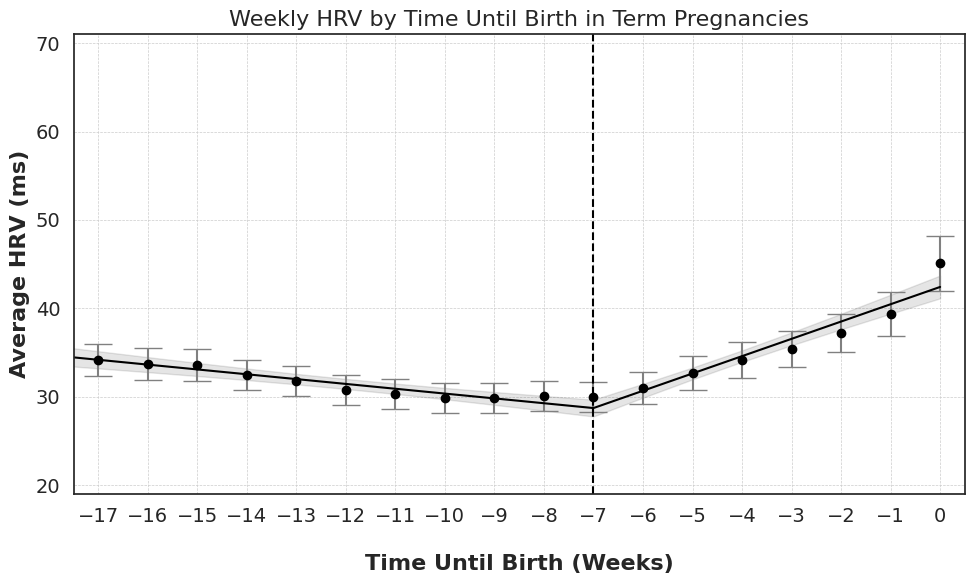

In [17]:
# Preprocess and calculate necessary columns
df = findDaysSince(df_sleep)
# Only include id's within the term group
df = df[df['record_id'].isin(term_group)]

df['daysSince'] = df['daysSince'] / np.timedelta64(1, 'D')
df['weeksSince'] = np.floor(df['daysSince'] / 7)
# remove rows with na values in rmssd
df = df.dropna(subset=['rmssd'])

# Filter from week 24 to delivery
df_filtered = df[(df['weeksSince'] >= -18) & (df['weeksSince'] <= 0)]

# Calculate weekly means and SEM
individual_weekly_hrv = df_filtered.groupby(['record_id', 'weeksSince']).agg(individual_mean_hrv=('rmssd', 'mean')).reset_index()
weekly_hrv = individual_weekly_hrv.groupby('weeksSince').agg(mean_hrv=('individual_mean_hrv', 'mean'), sem_hrv=('individual_mean_hrv', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()

# Define spline regression model with a knot at -7
weekly_hrv['knot'] = weekly_hrv['weeksSince'].apply(lambda x: max(0, x + 7))
model = smf.ols(formula='mean_hrv ~ weeksSince + knot', data=weekly_hrv).fit()
weekly_hrv['trend'] = model.predict(weekly_hrv)
# Calculate confidence intervals for the trend
predictions = model.get_prediction(weekly_hrv)
ci = predictions.conf_int()
lower_ci = ci[:, 0]
upper_ci = ci[:, 1]

# Plotting
plt.figure(figsize=(10, 6))

# Set to default seaborn theme
sns.set_theme(style="white", palette=None)
# Mean HRV with error bars
plt.errorbar(weekly_hrv['weeksSince'], weekly_hrv['mean_hrv'], yerr=1.96*weekly_hrv['sem_hrv'], fmt='o', color='black', ecolor='gray', capsize=10, label='Mean HRV with 95% CI')
# Trend line
plt.plot(weekly_hrv['weeksSince'], weekly_hrv['trend'], color='black', label='Trend Line')
# Confidence interval shading
plt.fill_between(weekly_hrv['weeksSince'], lower_ci, upper_ci, color='black', alpha=0.1, label='95% CI of Trend')

# Set x-ticks
plt.xticks(np.arange(-18, 1, 1), fontsize=14)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Labels and title
plt.title('Weekly HRV by Time Until Birth in Term Pregnancies', fontsize=16, fontweight='bold')
plt.xlabel('Time Until Birth (Weeks)', fontsize=16, labelpad=20, fontweight='bold')
plt.ylabel('Average HRV (ms)', fontsize=16, fontweight='bold')
plt.axvline(x=-7, color='black', linestyle='--')
plt.xlim(-17.5,0.5)
# Show the plot
plt.tight_layout()
plt.ylim(19, 71)
# plt.legend()
plt.yticks(fontsize=14)
plt.show()

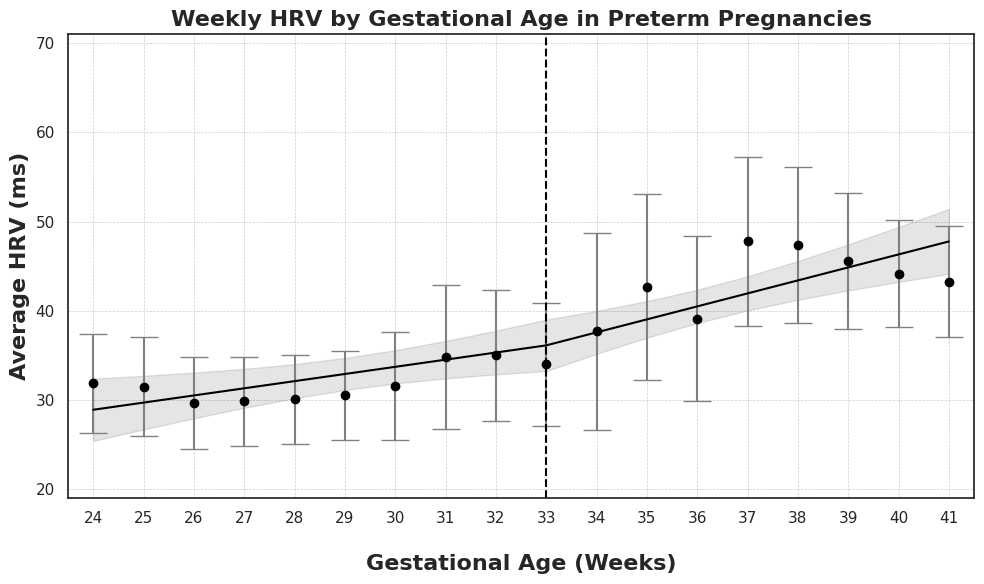

In [28]:
# Preprocess and calculate necessary columns
df = sleepTest.copy()  
# Only include id's within the term group
df = df[df['record_id'].isin(preterm_group)]

df['weeksSince'] = np.floor(df['gestationalAge'] / 7)  
# remove rows with na values in rmssd
df = df.dropna(subset=['rmssd'])

# Filter from week 24 to delivery
df_filtered = df[(df['weeksSince'] >= 24) & (df['weeksSince'] <= 41)]

# Calculate weekly means and SEM
individual_weekly_hrv = df_filtered.groupby(['record_id', 'weeksSince']).agg(individual_mean_hrv=('rmssd', 'mean')).reset_index()
weekly_hrv = individual_weekly_hrv.groupby('weeksSince').agg(mean_hrv=('individual_mean_hrv', 'mean'), sem_hrv=('individual_mean_hrv', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()

# spline regression model with a knot at 33 weeks
weekly_hrv['knot'] = weekly_hrv['weeksSince'].apply(lambda x: max(0, x - 33))  # Fix here
model = smf.ols(formula='mean_hrv ~ weeksSince + knot', data=weekly_hrv).fit()
weekly_hrv['trend'] = model.predict(weekly_hrv)
# Calculate confidence intervals for the trend
predictions = model.get_prediction(weekly_hrv)
ci = predictions.conf_int()
lower_ci = ci[:, 0]
upper_ci = ci[:, 1]

# Plotting
plt.figure(figsize=(10, 6))
# Mean HRV with error bars
plt.errorbar(weekly_hrv['weeksSince'], weekly_hrv['mean_hrv'], yerr=1.96*weekly_hrv['sem_hrv'], fmt='o', color='black', ecolor='gray', capsize=10, label='Mean HRV with 95% CI')
# Trend line
plt.plot(weekly_hrv['weeksSince'], weekly_hrv['trend'], color='black', label='Trend Line')
# Confidence interval shading
plt.fill_between(weekly_hrv['weeksSince'], lower_ci, upper_ci, color='black', alpha=0.1, label='95% CI of Trend')

# Set x-ticks
plt.xticks(np.arange(24, 42, 1))

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Labels and title
plt.title('Weekly HRV by Gestational Age in Preterm Pregnancies', fontsize=16,  fontweight='bold')
plt.xlabel('Gestational Age (Weeks)', fontsize=16, labelpad=20, fontweight='bold')
plt.ylabel('Average HRV (ms)', fontsize=16, fontweight='bold')
plt.axvline(x=33, color='black', linestyle='--')
plt.xlim(23.5, 41.5)
# Show the plot
plt.tight_layout()
# plt.legend()
plt.ylim(19, 71)
plt.show()

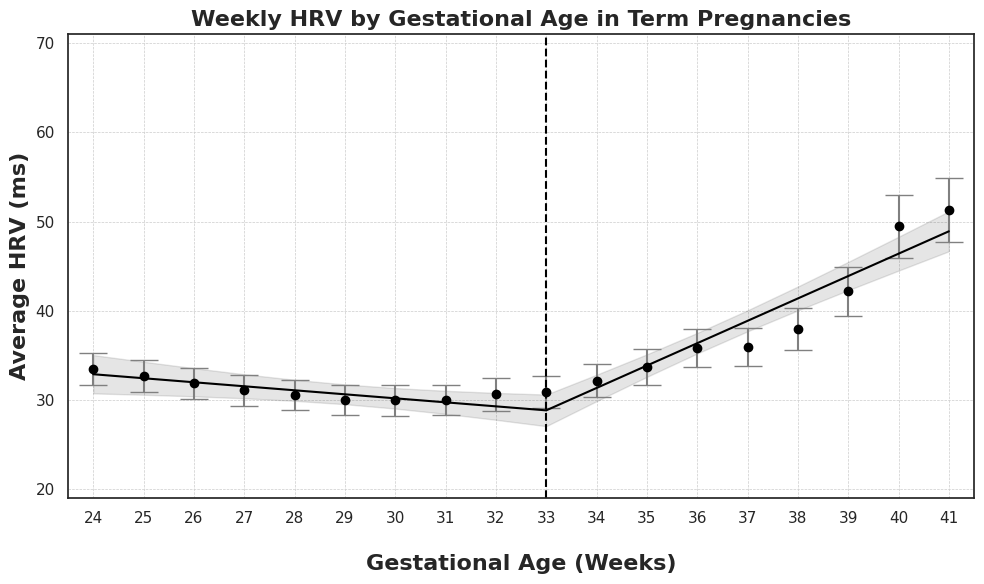

In [34]:
# Preprocess and calculate necessary columns
df = sleepTest.copy()  # Use sleepTest instead of df_sleep
# Only include id's within the term group
df = df[df['record_id'].isin(term_group)]

df['weeksSince'] = np.floor(df['gestationalAge'] / 7)  
# remove rows with na values in rmssd
df = df.dropna(subset=['rmssd'])

# Filter for pregnancies from week 24 to delivery
df_filtered = df[(df['weeksSince'] >= 24) & (df['weeksSince'] <= 41)]

# Calculate weekly means and SEM
individual_weekly_hrv = df_filtered.groupby(['record_id', 'weeksSince']).agg(individual_mean_hrv=('rmssd', 'mean')).reset_index()
weekly_hrv = individual_weekly_hrv.groupby('weeksSince').agg(mean_hrv=('individual_mean_hrv', 'mean'), sem_hrv=('individual_mean_hrv', lambda x: np.std(x) / np.sqrt(len(x)))).reset_index()

# spline regression model with a knot at 33 weeks
weekly_hrv['knot'] = weekly_hrv['weeksSince'].apply(lambda x: max(0, x - 33))  # Fix here
model = smf.ols(formula='mean_hrv ~ weeksSince + knot', data=weekly_hrv).fit()
weekly_hrv['trend'] = model.predict(weekly_hrv)
# Calculate confidence intervals for the trend
predictions = model.get_prediction(weekly_hrv)
ci = predictions.conf_int()
lower_ci = ci[:, 0]
upper_ci = ci[:, 1]

# Plotting
plt.figure(figsize=(10, 6))
# Mean HRV with error bars
plt.errorbar(weekly_hrv['weeksSince'], weekly_hrv['mean_hrv'], yerr=1.96*weekly_hrv['sem_hrv'], fmt='o', color='black', ecolor='gray', capsize=10, label='Mean HRV with 95% CI')
# Trend line
plt.plot(weekly_hrv['weeksSince'], weekly_hrv['trend'], color='black', label='Trend Line')
# Confidence interval shading
plt.fill_between(weekly_hrv['weeksSince'], lower_ci, upper_ci, color='black', alpha=0.1, label='95% CI of Trend')

# Set x-ticks
plt.xticks(np.arange(24, 42, 1))

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Labels and title
plt.title('Weekly HRV by Gestational Age in Term Pregnancies', fontsize=16,  fontweight='bold')
plt.xlabel('Gestational Age (Weeks)', fontsize=16, labelpad=20, fontweight='bold')
plt.ylabel('Average HRV (ms)', fontsize=16, fontweight='bold')
plt.axvline(x=33, color='black', linestyle='--')
plt.xlim(23.5, 41.5)
# Show the plot
plt.tight_layout()
# plt.legend()
plt.ylim(19, 71)
plt.show()

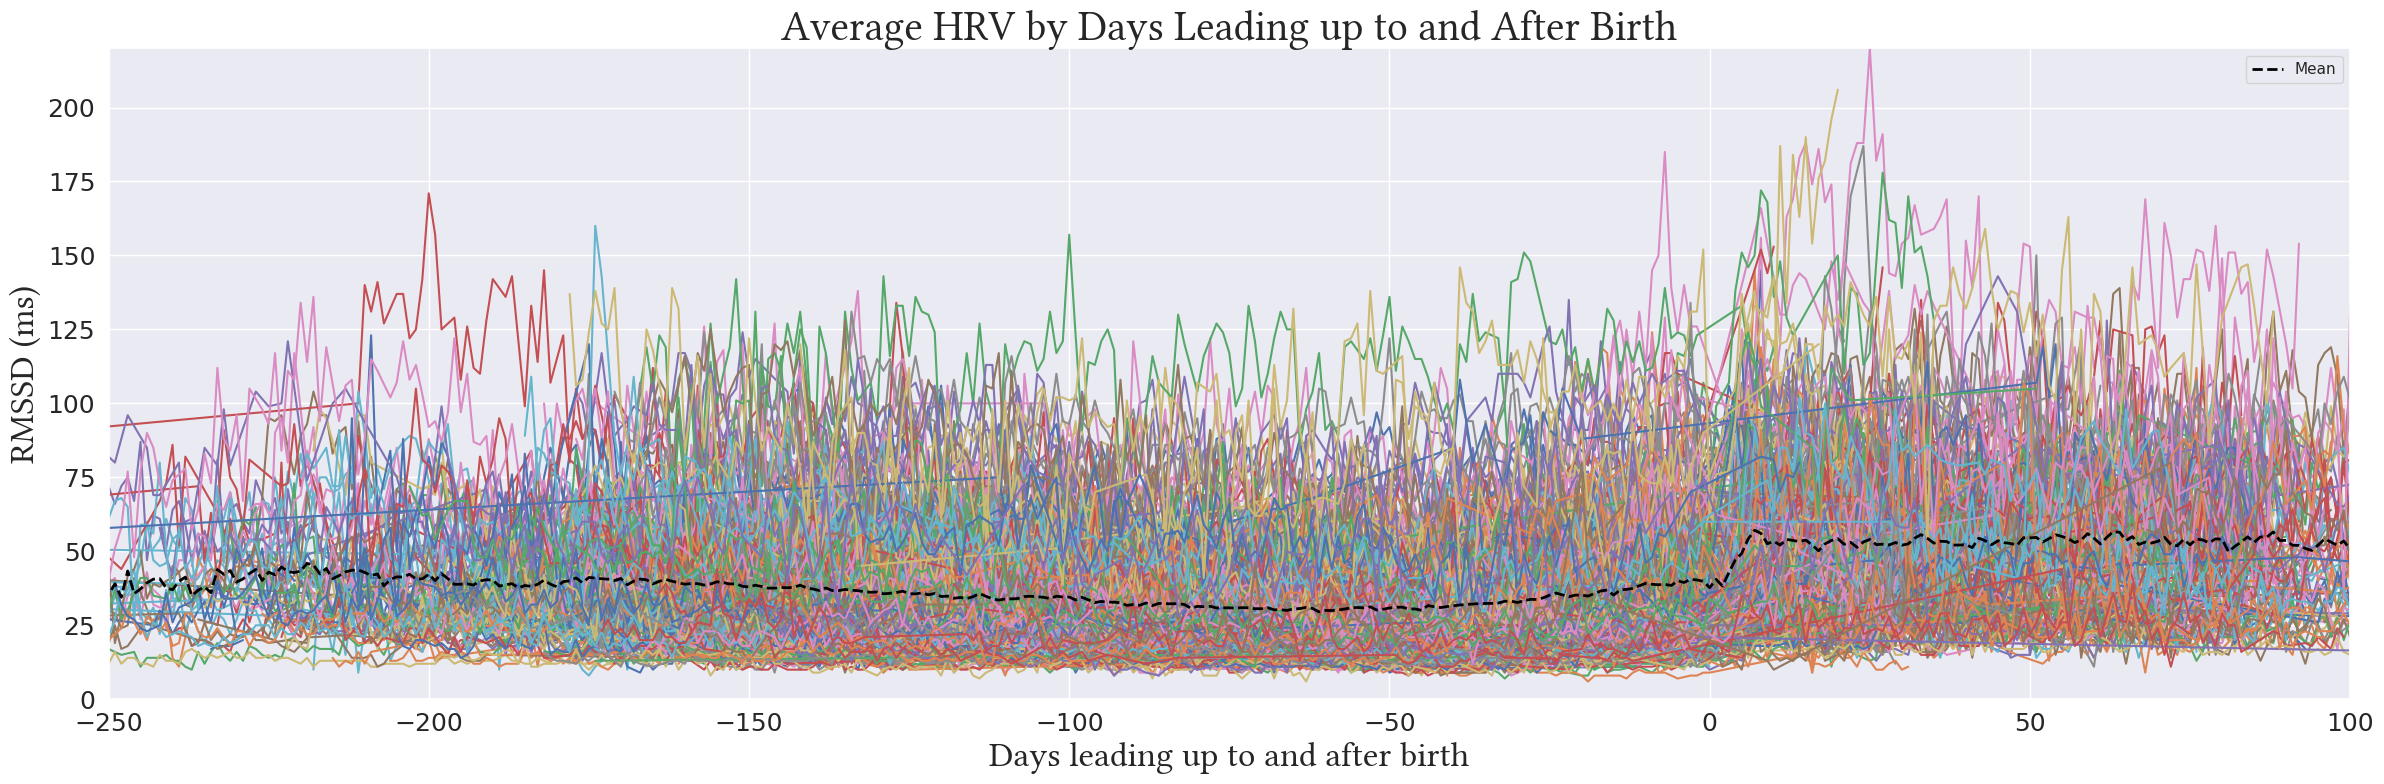

In [38]:
# Get individual user data
def getUser(df, user, variable):
    dfUser = df[df.record_id == user]
    dfUser = dfUser.set_index('daysSince')
    dfUser = dfUser.resample('1D')[variable].mean()
    dfUser.name = 'value'
    dfUser = dfUser.reset_index('daysSince')
    dfUser['daysSince'] = (dfUser['daysSince'] / np.timedelta64(1, 'D')).astype(int)
    return dfUser

def bumpFigSingle(df1, v1, ylabel, fileName, userList, ymin=None, ymax=None):
    
    # Setup figure
    fig = plt.figure(figsize=(24,8))
    
    palette = sns.color_palette('muted')

    plt.rcParams.update({'figure.max_open_warning': 0})
    sns.set_theme(style='darkgrid')
    
    df1 = findDaysSince(df1)
    
    # Generate dataframe to hold individual user data
    totalDF1 = pd.DataFrame(columns = ['daysSince', 'value', 'record_id'])
    
    # Plot each user
    for user in userList:
        dfUser1 = getUser(df1, user, v1)
        if (len(dfUser1) == 0):
            # print(str(user) + ' missing variable 1')
            continue
        sns.lineplot(data=dfUser1, x='daysSince', y='value', ci=None)

        totalDF1 = pd.concat([totalDF1, dfUser1])
        
    totalDF1 = totalDF1.groupby('daysSince').mean()
    
    # Plot mean line across all users
    sns.lineplot(data=totalDF1, x='daysSince', y='value', linewidth=2, ci=None, color='black', linestyle="dashed", label='Mean')
    
    plt.xlim(-250, 100)
    
    
    plt.ylabel(ylabel, fontproperties = fm.FontProperties(fname=path, size=25))  
    plt.ylim(ymin, ymax)

    plt.xlabel('Days leading up to and after birth', fontproperties = fm.FontProperties(fname=path, size=25)) 
    plt.title('Average HRV by Days Leading up to and After Birth', fontproperties = fm.FontProperties(fname=path, size=30))  

    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
    fig.tight_layout()
    fig.show()

bumpFigSingle(df_sleep, 'rmssd', 'RMSSD (ms)', 'rmssd', df_sleep.record_id.unique(), 0, 220)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7620bfb1-ec89-4c8d-8f2b-c4a71ff2ffdb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>